### Problem geometry
We want to model a fracture of fixed length $c$ in a homogeneous medium. The wellbore is considered too small compared to the extent of the fracture so we will not model it. We will simplify the problem using it's symmetry around the fracture, only modelling the upper quadrant of the domain.

![alt text](../Report/fracture.svg)

In [1]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix
from scipy import stats

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

import Mesher
import Matrix
import PoroElasticProperties as prop

In [2]:
# we create a folder to store the figures created
import os

try:
    os.makedirs('../Figures')
except OSError:
    pass

Mesh has 1293 nodes


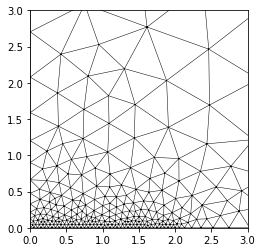

In [5]:
frac_length = 1.0
box_length = 20 * frac_length

cell_size = 0.05
factor = 100

import pygmsh
with pygmsh.geo.Geometry() as geom:
    p00 = geom.add_point([0, 0], cell_size)
    pfrac = geom.add_point([frac_length, 0], cell_size)
    pfrac2 = geom.add_point([2*frac_length, 0], cell_size)
    p10 = geom.add_point([box_length, 0], cell_size * factor)
    p11 = geom.add_point([box_length, box_length], cell_size * factor)
    p01 = geom.add_point([0, box_length], cell_size * factor)

    fracture = geom.add_line(p00, pfrac)
    bottom_refined = geom.add_line(pfrac, pfrac2)
    bottom = geom.add_line(pfrac2, p10)
    right = geom.add_line(p10, p11)
    top = geom.add_line(p11, p01)
    left = geom.add_line(p01, p00)

    loop = geom.add_curve_loop([fracture, bottom_refined, bottom, right, top, left])
    surface = geom.add_plane_surface(loop)
    out = geom.generate_mesh()

mesh = Mesher.Mesh(out)
mesh.plot()
plt.xlim(0, 3*frac_length)
plt.ylim(0, 3*frac_length)
mesh = Mesher.tri3_2_tri6(mesh)

print(f'Mesh has {mesh.nn} nodes')

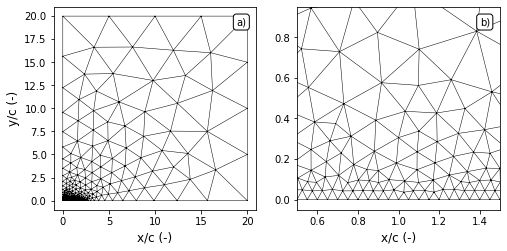

In [6]:

# what does those boundary look like
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
mesh.plot(ax=axs[0])
mesh.plot(ax=axs[1])

"""for ax in axs:
    ax.scatter(mesh.nodes[:, 0], mesh.nodes[:, 1], s=5, zorder=10, c='tab:orange')
    ax.scatter(mesh3.nodes[:, 0], mesh3.nodes[:, 1], s=5, zorder=10, c='tab:blue')"""

axs[0].set_xlabel('x/c (-)')
axs[1].set_xlabel('x/c (-)')
axs[0].set_ylabel('y/c (-)')


axs[1].set_xlim(0.5, frac_length + 0.5)
axs[1].set_ylim(-0.05, frac_length - 0.05)
[ax.set_aspect(1) for ax in axs]

letters = 'abcd'
for i, ax in enumerate(axs.flatten()):
    ax.text(0.95, 0.95, letters[i] + ')', ha='right', va='top', bbox={'color': 'w', 'ec': 'k', 'boxstyle': 'round'}, transform=ax.transAxes)

fig.savefig('../Figures/mesh.pdf', dpi=800, bbox_inches='tight')



## Boundary conditions

We want to enforce boundary conditions for every outer part of the domain as well as an initial stress and pressure state. For the first part, we need a logic to select the nodes located on the boundary of the domain, selecting the left, upper right and bottom boundaries. However, we need to distinguish where the fracture is located on the bottom boundary, as different conditions will be applied there. 

This leaves us with the following boundary conditions:
- no horizontal displacement and no flux on the left boundary,
- no vertical displacement and no flux on the bottom (past the fracture!) boundary,
- an initial stress state defined by applying an isotropic and homogeneous stress $\sigma_0$ at the top and right boundaries and
- an initial pressure $p_0$ applied everywhere in the domain. 

To ensure that we don't have edge effects from the boundary conditions at the top and right edges, we ensure that the domain is 20 times the fracture length $c$.

![alt text](fracture_boundaries.svg)

The boundary conditions at the fracture are the most important and definitely the most interesting. Two cases will be defined:
- an impermeable fracture scenario, where only a mechanical pressure $\sigma_{\text{frac}}$ is applied in the vertical direction and
- a permeable fracture scenario, where both a mechanical pressure $\sigma_{\text{frac}}$ and a fluid pressure $p_{\text{frac}}$ are applied. Note that $\sigma_{\text{frac}} = p_{\text{frac}}$.

[None, None]

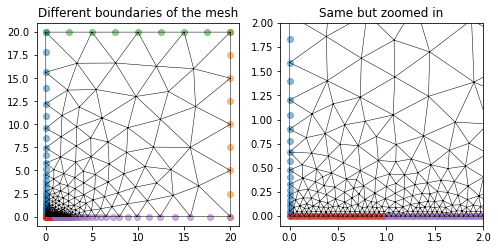

In [7]:
# we get the boundaries needed to enforce boundary conditions

# it is easy to select the left, right and top boundaries
# argwhere returns a vector of size (n, 1) and we want it to be one dimensional (n,) by selecting it's 0th column [:, 0]
left = np.argwhere(np.abs(mesh.nodes[:, 0] - mesh.nodes[:, 0].min()) <= 1e-4)[:, 0]
right = np.argwhere(np.abs(mesh.nodes[:, 0] - mesh.nodes[:, 0].max()) <= 1e-4)[:, 0]
top = np.argwhere(np.abs(mesh.nodes[:, 1] - mesh.nodes[:, 1].max()) <= 1e-4)[:, 0]

# we need a bit more logic to select the bottom fracture and the rest of the boundary
bottom = np.abs(mesh.nodes[:, 1] - 0) <= 1e-4
frac = mesh.nodes[:, 0] < frac_length
bottom_frac = np.argwhere(bottom & frac)[:, 0]
bottom_clear = np.argwhere(bottom & ~frac)[:, 0]

# what does those boundary look like
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
mesh.plot(ax=axs[0])
mesh.plot(ax=axs[1])
for cond in (left, right, top, bottom_frac, bottom_clear):
    axs[0].scatter(*mesh.nodes[cond].T, alpha=0.5)
    axs[1].scatter(*mesh.nodes[cond].T, alpha=0.5)

axs[0].set_title('Different boundaries of the mesh')
axs[1].set_title('Same but zoomed in')
axs[1].set_xlim(-0.1, 2*frac_length)
axs[1].set_ylim(-0.1, 2*frac_length)
[ax.set_aspect(1) for ax in axs]


## Geomechanical properties

For the sake of numerics, we need to use a few geomechanical properties, namely Young's modulus $E$, Poisson's ratio $\nu$, Biot's modulus $M$ and Biot's coefficient $\alpha$. We also need to define an hydraulic conductivity $\kappa$. We will set the first ones to some appropriate values for sandstone (Ohio sandstone in the course notes).

In [8]:
G = 6.8e3  # Shear modulus, in MPa
K = 8.4e3  # Bulk modulus, in Mpa
alpha = 0.71  # Biot's coefficient, adimensional
M = 9.18e3  # Biot's modulus, in Mpa
K_u = K + M*alpha*alpha # Undrained bulk modulus, in MPa

# we can use those values and the PoroElasticProperties.py library to easily convert those values to Young's modulus and Poisson's ratio, in the undrained and drained case
nu_u = prop.poisson_ratio(G, K_u) 
E_u = prop.young_modulus(G, K_u) 

nu = prop.poisson_ratio(G, K)  
E = prop.young_modulus(G, K) 

# Finally, we set the hydraulic conductivity (m/s) to some arbitrary  values
cond = 1.0e-9 # m/s


print(f'Undrained parameters: K_u = {K_u:.2f}, E = {E_u:.2f} MPa, nu = {nu_u:.3f}')
print(f'Drained parameters: E = {E:.2f} MPa, nu = {nu:.3f}')


Undrained parameters: K_u = 13027.64, E = 17376.65 MPa, nu = 0.278
Drained parameters: E = 16065.00 MPa, nu = 0.181


## Matrix assembly

We now need to assemble the matrices needed to solve the equation with respect to the mesh's elements and the geomechanical properties. 
This can be synthesized to the following system of ODEs:

\begin{equation}
\begin{bmatrix}
\mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{C} \\
\end{bmatrix}
\begin{pmatrix}
\mathbf{u} \\
\mathbf{p} \\
\end{pmatrix}
+
\begin{bmatrix}
\mathbf{K} & \mathbf{-A} \\
\mathbf{-A^T} & \mathbf{-S} \\
\end{bmatrix}
\begin{pmatrix}
\dot{\mathbf{u}} \\
\dot{\mathbf{p}} \\
\end{pmatrix}
=
\begin{pmatrix}
\dot{\mathbf{f}_t} \\
{\mathbf{f}_q} \\
\end{pmatrix}.
\end{equation}

For time integrating this scheme, we then compute:

\begin{equation}
\begin{bmatrix}
\mathbf{K} & \mathbf{-A} \\
\mathbf{-A^T} & \mathbf{-S} - \Delta t\mathbf{C}  \\
\end{bmatrix}
\begin{pmatrix}
\Delta\mathbf{u}^n \\
\Delta\mathbf{p}^n \\
\end{pmatrix}
=
\Delta t
\begin{pmatrix}
\dot{\mathbf{f}_t} \\
\mathbf{f}_q \\
\end{pmatrix}
-
\begin{bmatrix}
\mathbf{0} & \mathbf{0} \\
\mathbf{0} & -\Delta t\mathbf{C} \\
\end{bmatrix}
\begin{pmatrix}
\mathbf{u}^n \\
\mathbf{p}^n \\
\end{pmatrix}
=
\mathbf{f}_{\text{tot}}
\end{equation}

where $\mathbf{u}^n$ and $\mathbf{p}^n$ are the displacements and pressure at iteration $n$, $\Delta t$ is the time step, $\dot{\mathbf{f}_t}$ and ${\mathbf{f}_q}$ represent the force vector, $\mathbf{K}$ is the stiffness matrix, $\mathbf{S}$ the storage matrix, $\mathbf{C}$ the conductivity matrix and $\mathbf{A}$ the coupling matrix between elasticity and fluid flow. Together they are equivalent to the total matrix $\mathbf{T}$, equal to

\begin{equation}
\mathbf{T} = 
\begin{bmatrix}
\mathbf{K} & \mathbf{-A} \\
\mathbf{-A^T} & \mathbf{-S} - \Delta t\mathbf{C}  \\
\end{bmatrix}.
\end{equation}

Finally, we can compute the update vector $\boldsymbol{\Delta}^n = \begin{pmatrix}
\Delta\mathbf{u}^n \\
\Delta\mathbf{p}^n \\
\end{pmatrix}$
by inverting the total matrix and multiplying the force vector, such that updated displacements and pressure are equal to:

\begin{equation}
\begin{pmatrix}
\mathbf{u}^{n+1} \\
\mathbf{p}^{n+1} \\
\end{pmatrix}
=
\mathbf{T}^{-1}\mathbf{f_{\text{tot}}}
+
\begin{pmatrix}
\mathbf{u}^{n} \\
\mathbf{p}^{n} \\
\end{pmatrix}.
\end{equation}


c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


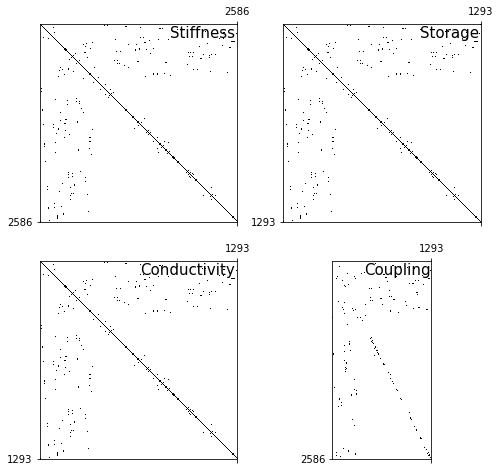

In [9]:
# Assembly of the different matrices. 
# The Matrix.py file contains all of the necessary functions to build them akin to the matlab code (for our 2d planar strain example)
stiffness = Matrix.assemble_stiffness_matrix(mesh, E, nu)
storage = Matrix.assemble_mass_matrix(mesh, 1/M)
conductivity = Matrix.assemble_conductivity_matrix(mesh, cond)
coupling = Matrix.assemble_coupling_matrix(mesh, alpha)

# what do those matrices look like?
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
matrices = [stiffness, storage, conductivity, coupling]
names = ['Stiffness', 'Storage', 'Conductivity', 'Coupling']
for i, (ax, matrix) in enumerate(zip(axs.flatten(), matrices)):
    ax.spy(matrix.toarray())#, aspect='auto')
    ax.text(0.99, 0.99, names[i], size=15, va='top', ha='right', transform=ax.transAxes)
    h, w = matrix.shape
    ax.set_xticks([w-1])
    ax.set_xticklabels([w])

    ax.set_yticks([h-1])
    ax.set_yticklabels([h])

fig.savefig('../Figures/matrices.pdf', dpi=800, bbox_inches='tight')


c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


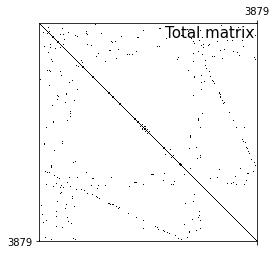

In [10]:
# We can also assemble the total matrix T
dt = 0 # dt needs to be set to 0 for the undrained case
AA = storage + dt*conductivity

ntot_E = mesh.nn*2
ntot_P = mesh.nn
ntot = ntot_E + ntot_P

T = csc_matrix((ntot, ntot))
T[:ntot_E, :ntot_E] = stiffness
T[ntot_E:, :ntot_E] = -coupling.T
T[:ntot_E, ntot_E:] = -coupling
T[ntot_E:, ntot_E:] = -AA

plt.spy(T.toarray(), aspect=1)
plt.text(0.99, 0.99, 'Total matrix', size=15, va='top', ha='right', transform=plt.gca().transAxes)

h, w = T.shape
ax = plt.gca()
ax.set_xticks([w-1])
ax.set_xticklabels([w])

ax.set_yticks([h-1])
ax.set_yticklabels([h])

fig.savefig('../Figures/Tmat.pdf', dpi=800, bbox_inches='tight')

## Solving for the undrained case
For the initial time $t=0$, we solve for an undrained displacement. Virtually, the time step $\Delta t=0$ (and was defined this way in the last cell). 

In this next cell, we then:
- Define the boundary conditions by selecting the proper degrees of freedoms for the displacements and the pore pressure
- Construct the force vector resulting from those boundary conditions
- Define an impermeable fracture case
- Solve for the undrained case

In [11]:
# there won't be any vertical displacement for the nodes after the fracture
# we get the corresponding degree of freedom for the boundaries with no displacement
dof_left = 2*left
dof_bottom = 2*bottom_clear + 1
nodes_fixed = np.unique(np.hstack((left, bottom_clear)))
dof_fixed = np.unique(np.hstack((dof_left, dof_bottom)))

# we set the initial stress field
sigma0 = 0  # Initial mean stress
p0 = 0  # Initial pressure everywhere [Mpa]
p_frac = 100  # [MPa]

stress_field = -np.array([sigma0, sigma0, 0])
sigma = Matrix.set_stress_field(mesh, stress_field)
fx_right = np.sum(sigma[right * 2]) / box_length
fy_top = np.sum(sigma[top * 2 + 1]) / box_length

# we assemble the force vector
fx = Matrix.assemble_tractions_over_line(mesh, right, [fx_right, 0])
fy = Matrix.assemble_tractions_over_line(mesh, top, [0, fy_top])
ffrac = Matrix.assemble_tractions_over_line(mesh, bottom_frac, [0, p_frac])
f = fx + fy - sigma + ffrac 

# we set the initial pore pressure field
impermeable_pore_pressure_free = np.arange(mesh.nn)  
permeable_pore_pressure_free = np.setdiff1d(np.arange(mesh.nn), bottom_frac)  

permeability = [impermeable_pore_pressure_free, permeable_pore_pressure_free]
undrained_solutions = []

mass = None
for i in range(2):
    pore_pressure_free = permeability[i]
    pore_pressure_fixed = np.setdiff1d(np.arange(mesh.nn), pore_pressure_free)
    h = np.zeros(mesh.nn)
    h[pore_pressure_fixed] = p_frac
    h[pore_pressure_free] = p0

    # we can now build the parts of the equations that we want to solve
    displacement_free = np.setdiff1d(np.arange(ntot_E), dof_fixed)
    eq_free = np.hstack([displacement_free, pore_pressure_free + ntot_E])
    eq_fixed = np.setdiff1d(np.arange(ntot), eq_free)

    # setting the force vector to the initial conditions according to pore pressure
    ftot = lil_matrix((ntot, 1))
    ftot[:ntot_E] = f - coupling @ h
    ftot[ntot_E:] = -AA @ h

    # we solve the system
    sol_undrained = lil_matrix((ntot, 1))
    sol_undrained[eq_free] = linalg.spsolve(T[eq_free][:, eq_free], ftot[eq_free])
    sol_undrained[pore_pressure_fixed + ntot_E] = p_frac

    # we reorder the solution vector in a practical way
    displacement = sol_undrained.toarray()[:ntot_E, 0].reshape(2, -1, order='F')
    pressure = sol_undrained.toarray()[ntot_E:, 0]

    # we want to look at the undrained behavior of the problem
    du, mass = Matrix.project_stress(mesh, E_u, nu_u, sol_undrained[:ntot_E].toarray(), M=mass, return_M=True)
    dp = Matrix.project_flux(mesh, cond, sol_undrained[ntot_E:].toarray(), M=mass, return_M=False)
    solution = {'solution': sol_undrained,    
                'displacement': displacement,
                'pressure': pressure,
                'du': du,
                'dp': dp}
    undrained_solutions.append(solution)

../FEM\Element.py:306: RuntimeWarning: divide by zero encountered in true_divide
  DNaDX = DN/j
../FEM\Element.py:306: RuntimeWarning: invalid value encountered in true_divide
  DNaDX = DN/j
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [12]:
# we can compute the analytical solution corresponding to some author
def analytical_disp(x, pressure0, c, poisson, young):
    p2 = 1 - poisson*poisson
    epsilon = (2*p2*pressure0*c)/young
    ratio = x/c
    w = epsilon*np.sqrt(1 - ratio*ratio)
    return w

def analytical_stress(x, c, p0):
    imag = 1j
    y = 0
    z = x + y*imag
    Z = p0 * (z/(np.sqrt(z**2 - c**2))-1)
    sx = Z.real - Z.conj().imag*y
    sy = Z.real + Z.conj().imag*y
    tau = -y * Z.conj().real
    
    return Z, (sx, sy, tau)

x_frac = np.sort(mesh.nodes[bottom, 0])
undrained_disp = analytical_disp(x_frac, p_frac, frac_length, nu_u, E_u)
drained_disp = analytical_disp(x_frac, p_frac, frac_length, nu, E)
Z, (sx, sy, tau) = analytical_stress(x_frac, frac_length, p_frac)


<ipython-input-12-c7e3b9272646>:6: RuntimeWarning: invalid value encountered in sqrt
  w = epsilon*np.sqrt(1 - ratio*ratio)
<ipython-input-12-c7e3b9272646>:13: RuntimeWarning: divide by zero encountered in true_divide
  Z = p0 * (z/(np.sqrt(z**2 - c**2))-1)
<ipython-input-12-c7e3b9272646>:13: RuntimeWarning: invalid value encountered in true_divide
  Z = p0 * (z/(np.sqrt(z**2 - c**2))-1)
<ipython-input-12-c7e3b9272646>:13: RuntimeWarning: invalid value encountered in multiply
  Z = p0 * (z/(np.sqrt(z**2 - c**2))-1)


### Normalizing the results

We can build normalization factors to try and generalize the results, independantly of units. 

Following (reference), the analytical solution for the vertical displacement at the fracture is:

$$
u_y = \epsilon\sqrt{1 - \left(\frac{x}{c}\right)^2 } 
$$

where 

$$
\epsilon = \frac{2c(1 - \sigma^2) \, p_{\text{frac}}}{E} \dot{=} [L].
$$

We can then normalize the resulting displacements $u_y$ by $\epsilon$, plotting the normalized displacements $u_y/\epsilon$ as a function of distance from crack length $c$, $x/c$. Since we chose a crack length of 1 meters, this is already the case by default.

We also need to normalize the stresses. Following (reference), this is easily done by dividing the computed stresses by $p_{\mathrm{frac}}$.

For the drained case, we will also need to normalize the results in time. The parameters related to the diffusion of the water through the medium are the principal contributors controlling the the time-dependant behavior of the phenomenon. Since our hydraulic conductivity $K$ has dimensions of $L\,T^{-1}$, we can normalize the time $t$ by multiplying it by a new coefficient

$$\theta = \frac{K}{\epsilon} \dot{=} [T^{-1}],$$

plotting our results as a function of $t\theta$.

In [13]:
epsilon = 2*(1 - nu_u**2)*p_frac*frac_length/E_u
theta = cond/epsilon

print(epsilon)
print(theta)

0.010622131969365739
9.414305931088064e-08


<ipython-input-14-452003179731>:10: RuntimeWarning: invalid value encountered in true_divide
  err1 = 100*(undrained_solutions[0]['displacement'][1, bottom][ii] - undrained_disp)/undrained_disp
<ipython-input-14-452003179731>:11: RuntimeWarning: invalid value encountered in true_divide
  err2 = 100*(undrained_solutions[1]['displacement'][1, bottom][ii] - undrained_disp)/undrained_disp


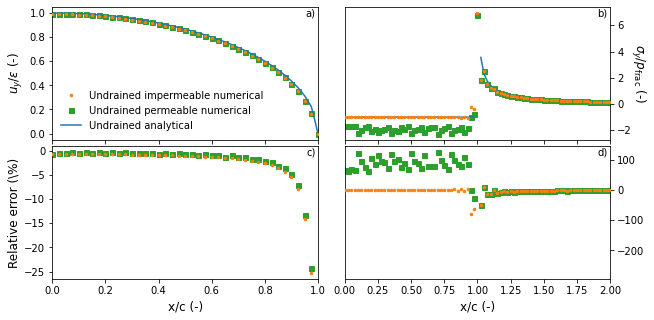

In [14]:
# comparing the analytical and numerical solution
X = mesh.nodes[bottom, 0]
ii = np.argsort(X)

fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
axs[0, 0].plot(X[ii], undrained_solutions[0]['displacement'][1, bottom][ii]/epsilon, c='tab:orange', label='Undrained impermeable numerical', ls='none', marker='.', ms=5, zorder=10)
axs[0, 0].plot(X[ii], undrained_solutions[1]['displacement'][1, bottom][ii]/epsilon, c='tab:green', label='Undrained permeable numerical', ls='none', marker='s', ms=5)
axs[0, 0].plot(x_frac, undrained_disp/epsilon, c='tab:blue', label='Undrained analytical')

err1 = 100*(undrained_solutions[0]['displacement'][1, bottom][ii] - undrained_disp)/undrained_disp
err2 = 100*(undrained_solutions[1]['displacement'][1, bottom][ii] - undrained_disp)/undrained_disp

axs[1, 0].plot(X[ii], err1, c='tab:orange', label='Undrained impermeable numerical', ls='none', marker='.', ms=5, zorder=10)
axs[1, 0].plot(X[ii], err2, c='tab:green', label='Undrained permeable numerical', ls='none', marker='s', ms=5)

axs[0, 0].set_xlim(0, frac_length)
axs[0, 0].set_ylabel('$u_y/\epsilon$ (-)')
axs[0, 0].legend(frameon=False)
axs[1, 0].set_ylabel('Relative error (\%)')
axs[1, 0].set_xlabel('x/c (-)')

axs[0, 1].plot(X[ii], undrained_solutions[0]['du'][1, bottom][ii]/p_frac, c='tab:orange', label='Undrained impermeable numerical', ls='none', marker='.', ms=5, zorder=10)
axs[0, 1].plot(X[ii], undrained_solutions[1]['du'][1, bottom][ii]/p_frac, c='tab:green', label='Undrained permeable numerical', ls='none', marker='s', ms=5)
axs[0, 1].plot(x_frac, sy/p_frac)

err1 = 100*(undrained_solutions[0]['du'][1, bottom][ii] - sy)/sy
err2 = 100*(undrained_solutions[1]['du'][1, bottom][ii] - sy)/sy

axs[1, 1].plot(X[ii], err1, c='tab:orange', label='Undrained impermeable numerical', ls='none', marker='.', ms=5, zorder=10)
axs[1, 1].plot(X[ii], err2, c='tab:green', label='Undrained permeable numerical', ls='none', marker='s', ms=5)

axs[1, 1].set_xlabel('x/c (-)')
axs[0, 1].set_xlim(0, 2*frac_length)
axs[0, 1].set_ylabel('$\sigma_y/p_{\mathrm{frac}}$ (-)', rotation=270, ha='center', va='center', labelpad=15)

axs[0, 1].yaxis.tick_right()
axs[0, 1].yaxis.set_label_position('right')
axs[1, 1].yaxis.tick_right()

fig.subplots_adjust(hspace=0.05, wspace=0.1)

letters = 'abcd'
for i, ax in enumerate(axs.flatten()):
    ax.text(0.99, 0.99, letters[i] + ')', ha='right', va='top', transform=ax.transAxes)

fig.savefig('../Figures/undrained.pdf', dpi=2000, bbox_inches='tight')


## Solving for the drained case
With the undrained case solved for in both the permeable and unpermeable cases, we can now solve for the drained case. 

In [15]:
# we want to make sure we compute long enough with respect to our drained normalization factors.

# we first compute our drained normalization factors
epsilon = 2*(1 - nu**2)*p_frac*frac_length/E
theta = cond/epsilon

print(epsilon)
print(theta)

# we artificially augment this number mainly for plotting results
max_t = 1.25/cond

print(max_t)

0.012040441176470589
8.305343511450382e-08
1250000000.0


In [1]:
# we want to compute the time varying solution on log-spaced time intervals
t = np.logspace(-4, np.log10(max_t), 75)
dt = np.diff(t)

drained_solutions = []

mass = None  # mass matrix used for computing derivatives, we don't need to compute it every time

for j in range(2):
    pore_pressure_free = permeability[j]
    pore_pressure_fixed = np.setdiff1d(np.arange(mesh.nn), pore_pressure_free)
    print(pore_pressure_fixed.shape)
    h = np.zeros(mesh.nn)
    h[pore_pressure_fixed] = p_frac
    h[pore_pressure_free] = p0

    # we can now build the parts of the equations that we want to solve
    displacement_free = np.setdiff1d(np.arange(ntot_E), dof_fixed)
    eq_free = np.hstack([displacement_free, pore_pressure_free + ntot_E])
    eq_fixed = np.setdiff1d(np.arange(ntot), eq_free)

    solutions = np.zeros((len(t), ntot))
    solutions[0] = undrained_solutions[j]['solution'].toarray()[:, 0]

    # do we want to keep on applying a mechanical pressure?
    ftot = lil_matrix((ntot, 1))
    ftot[ntot_E:] = -AA @ h

    from time import time

    t0 = time()
    for i, dt_i in enumerate(dt):
        print(f'\rSolving {i+1}/{len(dt)} = {(i+1)/len(dt)*100:.2f}%. Total computation time: {time() - t0:.2f} s', end='')
        # we adjust the total matrix with a varying dt
        T[ntot_E:, ntot_E:] = -(storage + dt_i * conductivity)

        # the change in flux is adjusted
        flux = dt_i * conductivity[pore_pressure_free].dot(solutions[i, ntot_E:])
        ftot[pore_pressure_free + ntot_E] = flux

        # we can solve the system
        update = linalg.spsolve(T[eq_free][:, eq_free], ftot[eq_free])
        solutions[i + 1, eq_free] = solutions[i, eq_free] + update
        solutions[i + 1 , pore_pressure_fixed + ntot_E] = p_frac

        print(f'\rSolving {i+1}/{len(dt)} = {(i+1)/len(dt)*100:.2f}%. Total computation time: {time() - t0:.2f} s', end='')        
        
    print(f'\nFinished computing the displacements and pressure for the {j+1} case.')

    # we can separate the displacements from the pore pressure to look at it
    displacement_field = solutions[:, :ntot_E].reshape(len(t), 2, -1, order='F')
    pore_pressure_field = solutions[:, ntot_E:]

    du = np.zeros((len(t), 3, mesh.nn))
    dp = np.zeros((len(t), 2, mesh.nn))

    t0 = time()
    for i in range(len(t)):
        print(f'\rSolving {i+1}/{len(t)} = {(i+1)/len(t)*100:.2f}%. Total computation time: {time() - t0:.2f} s', end='')
        du[i], mass = Matrix.project_stress(mesh, E, nu, solutions[i, :ntot_E][:, None], M=mass, return_M=True)  # effective stress here?
        dp[i] = Matrix.project_flux(mesh, cond, solutions[i, ntot_E:][:, None], M=mass, return_M=False)

    print(f'\nFinished computing the spatial derivatives for the case {j+1}')

    sol = {'solution': solutions,    
                'displacement': displacement_field,
                'pressure': pore_pressure_field,
                'du': du,
                'dp': dp}
    drained_solutions.append(sol)

NameError: name 'np' is not defined

<ipython-input-17-9deacf8dda7b>:10: RuntimeWarning: invalid value encountered in true_divide
  err1 = 100*(drained_solutions[0]['displacement'][-1, 1, bottom][ii] - drained_disp)/drained_disp
<ipython-input-17-9deacf8dda7b>:11: RuntimeWarning: invalid value encountered in true_divide
  err2 = 100*(drained_solutions[1]['displacement'][-1, 1, bottom][ii] - drained_disp)/drained_disp


0.02539719932936585


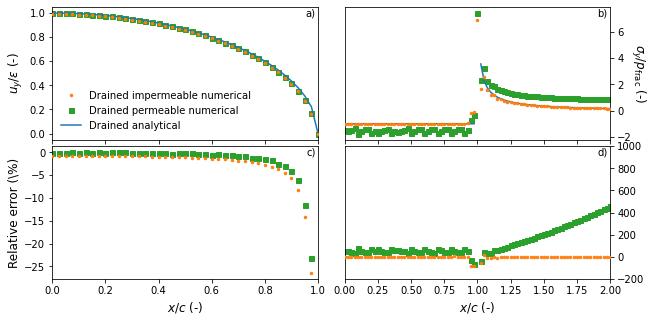

In [17]:
# comparing the analytical and numerical solution
X = mesh.nodes[bottom, 0]
ii = np.argsort(X)

fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
axs[0, 0].plot(X[ii], drained_solutions[0]['displacement'][-1, 1, bottom][ii]/epsilon, c='tab:orange', label='Drained impermeable numerical', ls='none', marker='.', ms=5, zorder=10)
axs[0, 0].plot(X[ii], drained_solutions[1]['displacement'][-1, 1, bottom][ii]/epsilon, c='tab:green', label='Drained permeable numerical', ls='none', marker='s', ms=5)
axs[0, 0].plot(x_frac, drained_disp/epsilon, c='tab:blue', label='Drained analytical')

err1 = 100*(drained_solutions[0]['displacement'][-1, 1, bottom][ii] - drained_disp)/drained_disp
err2 = 100*(drained_solutions[1]['displacement'][-1, 1, bottom][ii] - drained_disp)/drained_disp

print(np.nanmax(err2))

axs[1, 0].plot(X[ii], err1, c='tab:orange', label='Drained impermeable numerical', ls='none', marker='.', ms=5, zorder=10)
axs[1, 0].plot(X[ii], err2, c='tab:green', label='Drained permeable numerical', ls='none', marker='s', ms=5)


axs[0, 0].set_xlim(0, frac_length)
axs[0, 0].set_ylabel('$u_y/\epsilon$ (-)')
axs[0, 0].legend(frameon=False)
axs[1, 0].set_ylabel('Relative error (\%)')
axs[1, 0].set_xlabel('$x/c$ (-)')


axs[0, 1].plot(X[ii], drained_solutions[0]['du'][-1, 1, bottom][ii]/p_frac, c='tab:orange', label='Drained impermeable numerical', ls='none', marker='.', ms=5, zorder=10)
axs[0, 1].plot(X[ii], drained_solutions[1]['du'][-1, 1, bottom][ii]/p_frac, c='tab:green', label='Drained permeable numerical', ls='none', marker='s', ms=5)
axs[0, 1].plot(x_frac, sy/p_frac)

err1 = 100*(drained_solutions[0]['du'][-1, 1, bottom][ii] - sy)/sy
err2 = 100*(drained_solutions[1]['du'][-1, 1, bottom][ii] - sy)/sy


axs[1, 1].plot(X[ii], err1, c='tab:orange', label='Drained impermeable numerical', ls='none', marker='.', ms=5, zorder=10)
axs[1, 1].plot(X[ii], err2, c='tab:green', label='Drained permeable numerical', ls='none', marker='s', ms=5)

axs[1, 1].set_xlabel('$x/c$ (-)')
axs[0, 1].set_xlim(0, 2*frac_length)
axs[0, 1].set_ylabel('$\sigma_y/p_{\mathrm{frac}}$ (-)', rotation=270, ha='center', va='center', labelpad=15)

axs[0, 1].yaxis.tick_right()
axs[0, 1].yaxis.set_label_position('right')
axs[1, 1].yaxis.tick_right()
axs[1, 1].set_ylim(-200, 1000)
fig.subplots_adjust(hspace=0.05, wspace=0.1)

letters = 'abcd'
for i, ax in enumerate(axs.flatten()):
    ax.text(0.99, 0.99, letters[i] + ')', ha='right', va='top', transform=ax.transAxes)

fig.savefig('../Figures/drained.pdf', dpi=800, bbox_inches='tight', facecolor='white', transparent=False)


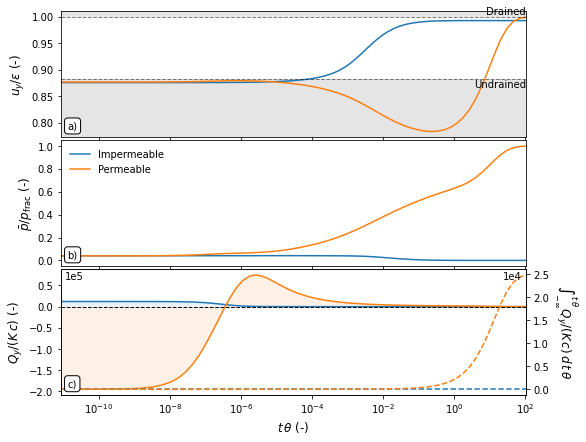

In [18]:
%matplotlib inline

# we want to plot the evolution of the fracture with respect to time

# we take the node corresponding at x=0, y=0
x0 = (mesh.nodes[:, 0] == 0) & (mesh.nodes[:, 1] == 0)

# we extract the vertical displacement solution for both numerical solutions
impermeable_sol = drained_solutions[0]['displacement'][:, 1, x0]/epsilon
permeable_sol = drained_solutions[1]['displacement'][:, 1, x0]/epsilon

# we also want to look at the evolution of the average pressure in the domain with respect to time
impermeable_pressure = drained_solutions[0]['pressure'][:, :].mean(axis=1)/p_frac
permeable_pressure = drained_solutions[1]['pressure'][:, :].mean(axis=1)/p_frac

# and also the flux at the fracture
impermeable_flux = drained_solutions[0]['dp'][:, 1, bottom_frac].sum(axis=1)*frac_length/cond
permeable_flux = drained_solutions[1]['dp'][:, 1, bottom_frac].sum(axis=1)*frac_length/cond

# we integrate the flux with respect to time to compute how much water has percolated
from scipy.integrate import cumtrapz
impermeable_Q = cumtrapz(impermeable_flux, theta*t, initial=0)
permeable_Q = cumtrapz(permeable_flux, theta*t, initial=0)

fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex='col')

# plotting the displacement
axs[0].semilogx(t*theta, impermeable_sol, label='Impermeable')
axs[0].semilogx(t*theta, permeable_sol, label='Permeable')

axs[0].set_xlim(t[0]*theta, t[-1]*theta)     
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

axs[0].axhline(undrained_disp[0]/epsilon, lw=1, ls='dashed', c='k', alpha=0.5)
axs[0].axhline(drained_disp[0]/epsilon, lw=1, ls='dashed', c='k', alpha=0.5)
axs[0].fill_between(xlim, ylim[0], undrained_disp[0]/epsilon, fc='k', alpha=0.1)
axs[0].fill_between(xlim, drained_disp[0]/epsilon, ylim[1], fc='k', alpha=0.1)
axs[0].text(t[-1]*theta, undrained_disp[0]/epsilon, 'Undrained', ha='right', va='top')
axs[0].text(t[-1]*theta, drained_disp[0]/epsilon, 'Drained', ha='right', va='bottom')
axs[0].set_ylim(ylim)

axs[0].set_ylabel('$u_y/\epsilon$ (-)')

# plotting the pressure
axs[1].semilogx(t*theta, impermeable_pressure, label='Impermeable')
axs[1].semilogx(t*theta, permeable_pressure, label='Permeable')

axs[1].set_xlabel('$t\,K/\epsilon$ (-)')
axs[1].set_ylabel('$\\bar{p}/p_{\mathrm{frac}}$ (-)')

# plotting the fluxes
axs[2].semilogx(t*theta, impermeable_flux, label='Impermeable')
axs[2].fill_between(t*theta, 0, impermeable_flux, fc='tab:blue', alpha=0.1)

axs[2].semilogx(t*theta, permeable_flux, label='Permeable')
axs[2].fill_between(t*theta, 0, permeable_flux, fc='tab:orange', alpha=0.1)

axs[2].axhline(0, c='k', ls='dashed', lw=1)
axs[2].ticklabel_format(axis='y', style='sci', scilimits=(5, 5))


ax2 = axs[2].twinx()
ax2.semilogx(t*theta, impermeable_Q, label='Impermeable', ls='dashed')
ax2.semilogx(t*theta, permeable_Q, label='Permeable', ls='dashed')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(4, 4))


axs[2].set_ylabel('$Q_y/(K\,c)$ (-)')
ax2.set_ylabel('$ \int_{-\infty}^{t\,\\theta} Q_y/(K\,c)\, d\,t\,\\theta$', rotation=270, ha='center', va='bottom')

# this part is to deal with annoying matplotlib code to change the offset (1eX) location
axs[2].yaxis.offsetText.set_visible(False)
ax2.yaxis.offsetText.set_visible(False)

fig.tight_layout(rect=[0, 0, 1, 1])
offset = axs[2].yaxis.get_major_formatter().get_offset()
axs[2].text(0.01, 0.9, offset, ha='left', va='bottom', transform=axs[2].transAxes)

offset = ax2.yaxis.get_major_formatter().get_offset()
ax2.text(0.99, 0.9, offset, ha='right', va='bottom', transform=ax2.transAxes)

# final tweaking of the plot
axs[1].legend(loc='upper left', frameon=False)
axs[-1].set_xlabel('$t\,\\theta$ (-)')

# annotating the plots with a) b) and c)
letters = 'abc'
for i, ax in enumerate((axs[0], axs[1], ax2)):
    ax.text(0.015, 0.05, letters[i] + ')', ha='left', va='bottom', bbox={'color': 'w', 'ec': 'k', 'boxstyle': 'round'}, transform=ax.transAxes)

fig.subplots_adjust(hspace=0.025)

fig.savefig('../Figures/time_behavior.pdf', dpi=800, bbox_inches='tight')

In [19]:
# An animation comparing the opening of the permeable and the impermeable fractures
# a different ploting backend is needed for the animations
%matplotlib qt

plt.rcParams['text.usetex'] = False
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Some ANIMATIONS funky fresh
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]

l1, = ax.plot(x_frac, drained_solutions[0]['displacement'][0, 1, bottom][ii]/epsilon)
l2, = ax.plot(x_frac, drained_solutions[1]['displacement'][0, 1, bottom][ii]/epsilon)

text = ax.set_title(f't $\\theta$ = $10^{{{np.log10(t[0]):.2f}}}$ s', loc='left')

ax.set_xlabel('$x/c$ (-)')
ax.set_ylabel('$u_y/\epsilon$ (-)', rotation=0, ha='right', va='center')
ymax = 1.3*max([drained_solutions[i]['displacement'][0, 1, bottom].max() for i in range(2)])/epsilon
ax.set_ylim(0, ymax)

ax.plot(x_frac, undrained_disp/epsilon, lw=1, ls='dashed', c='k', alpha=0.5)
ax.plot(x_frac, drained_disp/epsilon, lw=1, ls='dashed', c='k', alpha=0.5)

ax.fill_between(x_frac, 0, undrained_disp/epsilon, fc='k', alpha=0.1)
ax.fill_between(x_frac, drained_disp/epsilon, ymax, fc='k', alpha=0.1)# lw=1, ls='dashed', c='k')

ax.set_xlim(0, frac_length)

ax.text(0, (undrained_disp[0] - undrained_disp[0]*0.025)/epsilon, 'Undrained', ha='left', va='top')
ax.text(0, drained_disp[0]/epsilon, 'Drained', ha='left', va='bottom')
ax.legend((l1, l2), ('Impermeable', 'Permeable'), frameon=False, loc='lower right')

ax = axs[1]
l3, = ax.plot(x_frac, drained_solutions[0]['pressure'][0, bottom][ii]/p_frac)
l4, = ax.plot(x_frac, drained_solutions[1]['pressure'][0, bottom][ii]/p_frac, zorder=0)

axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position('right')
axs[1].set_xlim(0, 2*frac_length)
axs[1].set_xlabel('x/c (-)')
axs[1].set_ylabel('$p/p_{\mathrm{frac}}$ (-)', rotation=0, ha='left', va='center')#, labelpad=15)
axs[1].yaxis.set_major_locator(plt.MaxNLocator(5))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(4))


times = [f't$\\theta$ = $10^{{{np.log10(t[i]*theta):.2f}}}$ s' for i in range(len(t))]
def update(i, l1, l2, l3, l4, text):
    l1.set_data(x_frac, drained_solutions[0]['displacement'][i, 1, bottom][ii]/epsilon)
    l2.set_data(x_frac, drained_solutions[1]['displacement'][i, 1, bottom][ii]/epsilon)

    l3.set_data(x_frac, drained_solutions[0]['pressure'][i, bottom][ii]/p_frac)
    l4.set_data(x_frac, drained_solutions[1]['pressure'][i, bottom][ii]/p_frac)

    text.set_text(times[i])
    return l1, l2, l3, l4, text,

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50, repeat_delay=100, fargs=(l1, l2, l3, l4, text))

fig.set_facecolor('white')

plt.tight_layout()
plt.show()

FFwriter = FFMpegWriter(fps=15, codec='h264', bitrate=1e6)
ani.save('../Figures/fracture_opening.gif', writer=FFwriter)

In [20]:
%matplotlib qt
fig, axs = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(8, 4))

impermeable = drained_solutions[0]['pressure']
permeable = drained_solutions[1]['pressure']

vmin = min(impermeable.min(), permeable.min())
vmax = max(impermeable.max(), permeable.max())

im1 = axs[0].tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], impermeable[0], lw=1, shading='gouraud', 
                  vmin=vmin, vmax=vmax)
im2 = axs[1].tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], permeable[0], lw=1, shading='gouraud', 
                  vmin=vmin, vmax=vmax)

text = axs[0].set_title(f't$\\theta$ = $10^{{{np.log10(t[0]*theta):.2f}}}$ s', loc='left')

axs[0].set_xlim(0, 2*frac_length)
axs[0].set_ylim(0, 2*frac_length)

for ax in axs:
    ax.set_xlabel('x/c (m)')
    ax.set_aspect(1)
axs[0].set_ylabel('y/c (m)')

axs[0].xaxis.set_major_locator(plt.MaxNLocator(4))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(4))

axs[0].text(0.99, 1, 'Impermeable', ha='right', va='bottom', transform=axs[0].transAxes)
axs[1].text(0.99, 1, 'Permeable', ha='right', va='bottom', transform=axs[1].transAxes)

def update(i):
    text.set_text(f't$\\theta$ = $10^{{{np.log10(t[i]*theta):.2f}}}$ s')
    im1.set_array(impermeable[i])
    im2.set_array(permeable[i])
    return im1, im2, text

ani = FuncAnimation(fig, update, frames=len(t), blit=False, interval=50)
fig.set_facecolor('w')
FFwriter = FFMpegWriter(fps=15, codec='h264', bitrate=1e6)
ani.save('../Figures/pressure_evolution.gif', writer=FFwriter)
